# Link: https://medium.com/@mariumaslam499/build-your-own-ai-coding-agent-with-langgraph-040644343e73


In [1]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions from the coding assistant"""
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code Block import statements")
    code: str = Field(description="Code block not including import statements")

In [2]:
from langchain_core.prompts import ChatPromptTemplate
#from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os

load_dotenv()

code_system_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a python coding assistant with expertise in exploratory data analysis.
            Answer the user question relevant to the dataset provided by the user.
            The user will provide a dataset path from which you can read it.
            Ensure any code you provide can be executed with all required imports and variables defined.
            Structure your answer with a description of the code solution. 
            Then list the imports. 
            And finally list the functioning code block.""",
        ),
        (
            "placeholder", "{messages}"
        ),
        
    ]
)

#llm_model_name = "gpt-4o-mini"

#llm = ChatOpenAI(api_key=os.environ.get("OPENAI_API_KEY"), temperature=0, model=llm_model_name)
llm = ChatGroq(api_key=os.environ.get("GROQ_API_KEY"), temperature=0, model="meta-llama/llama-4-maverick-17b-128e-instruct")
code_agent_chain = code_system_prompt | llm.with_structured_output(code)

In [3]:
from typing import List
from typing_extensions import TypedDict

class State(TypedDict):
    """
    Represents the state of the Graph.
    Attributes:
    error : Binary flag for control flow to check whether test error was tripped
    next_step: Binary flag for control flow to check whether next step in code solution is required
    messages: chat history with user questions and AI responses
    generation: code solution
    iterations: number of tries

        
    """
    task: str
    error: str
    next_step: str
    messages: List
    generation: str
    iterations: int
    error_iterations: int

In [4]:
# Define the nodes
def generate(state: State):

    """
    Node to generate code solution

    Arguments:
        state (dict): The current graph state

    Returns:
        state (dict): The updated graph state

    """

    print("----- Generating Code -----")

    # Store State variables
    messages = state["messages"]
    error = state["error"]
    next_step = state["next_step"]
    iterations = state["iterations"]
    error_iterations = state["error_iterations"]
    task = state["task"]

    # if we have been routed back with error
    if error == "yes":
        # error fix prompt
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports and code block."
            )
        ]
        error = "no"
    
    else:
        messages+= [
            (
                "user",
                f"""
                    The user wants to complete this task: {task}.
                    Based on what you already know, do you need to inspect the dataset and its columns and unique values in the columns first? 
                    If yes, generate python code for it.
                    If no, generate the final solution.
                    Invoke the code tool to structure the output with a prefix, imports and code block."""
            )
        ]
    code_solution = code_agent_chain.invoke(
        {"messages": messages}
    )
    if code_solution.prefix == "end":
        next_step = "end"
    else:
        messages += [
            (
                "assistant",
                f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code Block: {code_solution.code}",
            )
        ]

    # Increment
    iterations = iterations+1
    
    return {"generation": code_solution, "messages": messages, "iterations": iterations, "error_iterations": error_iterations, "next_step": next_step, "error": error}

def execute_and_check_code(state: State):
    """
    Execute code and check for errors.
    
    Arguments:
        state (dict): The current Graph state.

    Returns:
        state (dict): The updated graph state.
    """

    print("----- Executing code -----")

    # storing state variables
    messages = state["messages"]
    error = state["error"]
    code_solution = state["generation"]
    iterations = state["iterations"]
    error_iterations = state["error_iterations"]
    next_step = state["next_step"]
    imports = code_solution.imports
    code_to_run = code_solution.code

    # check imports
    try:
        exec(imports)
    except Exception as e:
        print("---- Code Exceution Failed: Imports ----")
        error_message = [
            (
                "user",
                f"Your code solution failed the import test: {e}"
            )
        ]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error_iterations": error_iterations,
            "error": "yes"
        }
    
    # check execution
    try:
        exec(imports + "\n" + code_to_run)

    except Exception as e:
        print("---- Code Exceution Failed: Code Block ----")
        error_message = [
            (
                "user",
                f"Your code failed the code execution test: {e}"
            )
        ]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error_iterations": error_iterations,
            "error": "yes"

        }
    
    # No failures
    print("---- No Code Failures----")
    next_step = "yes"
    return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error_iterations": error_iterations,
            "next_step": next_step

        }
    
max_iters = 5
max_trys = 3

def decide_to_finish(state: State):

    """
    Checks whether maximum allowed iterations are over
    """

    iterations = state["iterations"]
    error_iterations = state["error_iterations"]
    next_step = state["next_step"]

    if iterations >= max_iters or error_iterations >= max_trys or next_step == "end":
        print("---DECISION: FINISH---")
        return "end"
    else:
        return "execute_code"

In [5]:
from langgraph.graph import END, StateGraph, START

workflow_builder = StateGraph(State)

# define the nodes
workflow_builder.add_node("generate", generate) # generate solution
workflow_builder.add_node("check_code", execute_and_check_code) # execute and check code

# Build Graph
workflow_builder.add_edge(START, "generate")
# workflow.add_edge("generate", "check_code")
workflow_builder.add_conditional_edges(
    "generate",
    decide_to_finish,
    {
        "end": END,
        "execute_code": "check_code"
    }
)
workflow_builder.add_edge("check_code", "generate")
workflow = workflow_builder.compile()

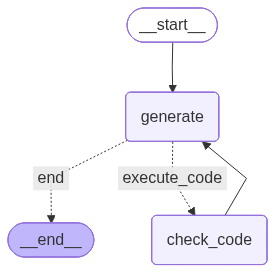

In [6]:
from IPython.display import Image, display

display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

In [7]:
question = """Write a python function that takes a list of numbers and returns the list sorted in ascending order without using the built-in sort function."""
solution = workflow.invoke({"task": question, "messages":[], "iterations": 0, "error": "", "next_step": "", "error_iterations": 0})

----- Generating Code -----


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'No, I don\'t need to inspect the dataset because the task is to write a Python function that takes a list of numbers and returns the list sorted in ascending order without using the built-in sort function. This task doesn\'t require any dataset.\n\nHere\'s the solution:\n\n### Prefix\nThe task requires implementing a sorting algorithm. I will use the Merge Sort algorithm, a divide-and-conquer algorithm that is suitable for this task.\n\n### Imports\nNo imports are required for this task as it only involves basic Python operations.\n\n### Code\n```python\ndef merge_sort(numbers):\n    if len(numbers) <= 1:\n        return numbers\n    mid = len(numbers) // 2\n    left_half = merge_sort(numbers[:mid])\n    right_half = merge_sort(numbers[mid:])\n    return merge(left_half, right_half)\n\ndef merge(left, right):\n    merged = []\n    left_index = 0\n    right_index = 0\n    while left_index < len(left) and right_index < len(right):\n        if left[left_index] <= right[right_index]:\n            merged.append(left[left_index])\n            left_index += 1\n        else:\n            merged.append(right[right_index])\n            right_index += 1\n    merged.extend(left[left_index:])\n    merged.extend(right[right_index:])\n    return merged\n\n# Example usage\nnumbers = [64, 34, 25, 12, 22, 11, 90]\nsorted_numbers = merge_sort(numbers)\nprint(sorted_numbers)\n```\n\nLet\'s invoke the code tool with the required output structure.\n\n[\n {\n "name": "code",\n "parameters": {\n "code": "def merge_sort(numbers):\\n    if len(numbers) <= 1:\\n        return numbers\\n    mid = len(numbers) // 2\\n    left_half = merge_sort(numbers[:mid])\\n    right_half = merge_sort(numbers[mid:])\\n    return merge(left_half, right_half)\\n\\ndef merge(left, right):\\n    merged = []\\n    left_index = 0\\n    right_index = 0\\n    while left_index < len(left) and right_index < len(right):\\n        if left[left_index] <= right[right_index]:\\n            merged.append(left[left_index])\\n            left_index += 1\\n        else:\\n            merged.append(right[right_index])\\n            right_index += 1\\n    merged.extend(left[left_index:])\\n    merged.extend(right[right_index:])\\n    return merged\\n\\n# Example usage\\nnumbers = [64, 34, 25, 12, 22, 11, 90]\\nsorted_numbers = merge_sort(numbers)\\nprint(sorted_numbers)",\n "imports": "",\n "prefix": "The task requires implementing a sorting algorithm. I will use the Merge Sort algorithm, a divide-and-conquer algorithm that is suitable for this task."\n }\n }\n]'}}

In [ ]:
solution

{'task': 'From the dataset located at: "13100326.csv", Explore the relationship between glucose levels and glycated hemoglobin A1c (HbA1c) percentages within specific age groups. Identify any correlations or patterns between these two key indicators of blood sugar control.',
 'error': 'no',
 'next_step': 'yes',
 'messages': [('user',
   '\n                    The user wants to complete this task: From the dataset located at: "13100326.csv", Explore the relationship between glucose levels and glycated hemoglobin A1c (HbA1c) percentages within specific age groups. Identify any correlations or patterns between these two key indicators of blood sugar control..\n                    Based on what you already know, do you need to inspect the dataset and its columns and unique values in the columns first? \n                    If yes, generate python code for it.\n                    If no, generate the final solution.\n                    Invoke the code tool to structure the output with a pr

# Using an Agent with the Python Repl Tool

In [8]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_groq import ChatGroq

@tool
def python_repl(code: str) -> str:
    """
    Use this function to execute Python code and get the results.
    """
    repl = PythonREPL()
    try:
        print("Running the Python REPL tool")
        print(code)
        result = repl.run(code)
        print(result)
    except BaseException as e:
        return f"Failed to execute. Error: {e!r}"
    return f"Result of code execution: {result}"

In [9]:
tools = [python_repl]
tools_by_name = {tool.name: tool for tool in tools}
#llm_model_name = "gpt-4o-mini"
#llm = ChatOpenAI(api_key=os.environ.get("OPENAI_API_KEY"), temperature=0, model=llm_model_name)
llm = ChatGroq(
                 temperature=0, model="meta-llama/llama-4-maverick-17b-128e-instruct")
llm_with_tools = llm.bind_tools(tools)


from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage

prompt = """You are a python coding assistant with expertise in exploratory data analysis.
            Answer the user question relevant to the dataset provided by the user.
            The user will provide a dataset path from which you can read it.
            Ensure any code you provide can be executed with all required imports and variables defined.
            Structure your answer with a description of the code solution. 
            Then list the imports. 
            And finally list the functioning code block."""
        


In [22]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions from the coding assistant"""
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code Block import statements")
    code: str = Field(description="Code block not including import statements")

In [ ]:
from langgraph.prebuilt import create_react_agent
llm_with_tools_2 = create_react_agent("groq:meta-llama/llama-4-maverick-17b-128e-instruct"
                                      ,[python_repl],
                                      prompt=prompt,
                                      response_format= code
                                            )

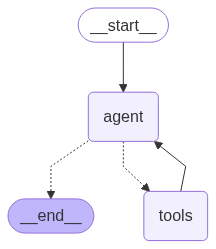

In [11]:
from IPython.display import Image, display

display(Image(llm_with_tools_2.get_graph(xray=True).draw_mermaid_png()))

In [26]:
from langchain_core.messages import HumanMessage
response = llm_with_tools_2.invoke(
    #{"messages": [HumanMessage(content="Write a python function that takes a list of numbers and returns the list sorted in ascending order without using the built-in sort function.")]}
    {"messages": [{"role": "user", "content": "Write a python function for fibonacci sequence"}]})

In [27]:
response

{'messages': [HumanMessage(content='Write a python function for fibonacci sequence', additional_kwargs={}, response_metadata={}, id='36238381-3418-4505-adf9-8a9d62d94ab1'),
  AIMessage(content='To generate a Fibonacci sequence in Python, we can define a function that takes the number of terms as input and returns a list containing the Fibonacci sequence up to that number of terms.\n\n### Description of the Code Solution\nThe function `generate_fibonacci` will take an integer `n` as input, representing the number of terms in the Fibonacci sequence to generate. It will return a list of integers representing the Fibonacci sequence.\n\n### Imports\n- No external imports are required for this function.\n\n### Code\n```python\ndef generate_fibonacci(n):\n    """\n    Generate the Fibonacci sequence up to n terms.\n\n    Args:\n        n (int): The number of terms in the Fibonacci sequence.\n\n    Returns:\n        list: A list of integers representing the Fibonacci sequence.\n    """\n    if

In [30]:
response['structured_response'].code.split("\n")

['def generate_fibonacci(n):',
 ' if n <=0:',
 ' return []',
 ' elif n ==1:',
 ' return [0]',
 ' elif n ==2:',
 ' return [0,1]',
 ' else:',
 ' fib_sequence = [0,1]',
 ' while len(fib_sequence) < n:',
 ' fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])',
 ' return fib_sequence']

In [ ]:
class State(TypedDict):
    """
    Represents the state of the Graph.
    """
    user_input: str  # User’s task request
    messages: List   # Chat history (questions, responses, tool outputs)
    new_input: str   # Flag to check for new user input
    code: str        # Stores the generated Python code
    iterations: int  # Tracks the number of execution attempts
    final_response: List  # Stores the final response after execution

def tool_node(state: State):
    """Performs the tool call"""
    result = []
    messages = state["messages"]
    
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": messages + result}

In [ ]:
from typing import Literal
def should_continue(state: State) -> Literal["environment", END]:
    """
    Decide if we should continue execution or stop.
    """
    messages = state["messages"]
    last_message = messages[-1]
    iterations = state["iterations"]
    
    if iterations > max_iters:
        return END  # Stop execution if max iterations are reached
    if last_message.tool_calls:
        return "Action"  # Continue execution if the LLM made a tool call
    return END

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
def llm_call(state: State):
    """
    The LLM agent node. Generates code, calls tools, and analyzes results.
    """
    print("----- Calling LLM -----")
    messages = state["messages"]
    user_input = state["user_input"]
    iterations = state["iterations"]
    new_input = state["new_input"]

    if len(messages) == 0:
        messages += [
            SystemMessage(content="""You are a Python coding assistant with expertise in exploratory data analysis.
            Use the python_repl tool to execute the code. If an error occurs, resolve it and retry up to 3 times.
            Once execution succeeds, analyze the result and provide insights.
            Structure responses with a prefix, code block, result, and analysis."""
            )
        ]
    
    if new_input == "True": 
        messages += [
            HumanMessage(content=f"The user wants to complete this task: {user_input}. Use the Python REPL tool to complete the task.")
        ]
        new_input = "False"
                
    code_solution = llm_with_tools.invoke(messages)
    messages += [(code_solution)]
    
    iterations += 1
    return {"messages": messages, "final_response": code_solution, "iterations": iterations, "new_input": new_input}

In [ ]:
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "Action": "environment",
        END: END
    }
)
agent_builder.add_edge("environment", "llm_call")
agent = agent_builder.compile()

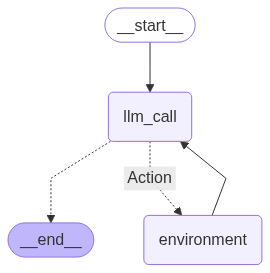

In [ ]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
question = """From the dataset located at: "13100326.csv", 
Explore the relationship between glucose levels and glycated hemoglobin A1c (HbA1c) percentages within specific age groups. 
Identify any correlations or patterns between these two key indicators of blood sugar control."""

solution = agent.invoke({"user_input": question, "messages":[], "iterations": 0, "new_input": "True"})

----- Calling LLM -----
Running the Python REPL tool
import pandas as pd; df = pd.read_csv('13100326.csv'); print(df.head())
FileNotFoundError(2, 'No such file or directory')
----- Calling LLM -----
Running the Python REPL tool
import pandas as pd; df = pd.read_csv('13100326.csv'); df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle_Aged', 'Old']); print(df.groupby('age_group')[['glucose', 'HbA1c']].corr())
FileNotFoundError(2, 'No such file or directory')
----- Calling LLM -----


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'The file "13100326.csv" was not found. Please ensure the file is in the correct location and try again.\n\n### Code\n```python\nimport pandas as pd\n\n# Load the dataset\ndf = pd.read_csv(\'13100326.csv\')\n\n# Create age groups\ndf[\'age_group\'] = pd.cut(df[\'age\'], bins=[0,30,50,100], labels=[\'Young\', \'Middle_Aged\', \'Old\'])\n\n# Explore the relationship between glucose levels and HbA1c percentages within specific age groups\nprint(df.groupby(\'age_group\')[[\'glucose\', \'HbA1c\']].corr())\n```\n\n### Result\nThe result will be a correlation matrix for each age group, showing the relationship between glucose levels and HbA1c percentages.\n\n### Analysis\nTo analyze the result, we will examine the correlation coefficient between glucose and HbA1c for each age group. A strong positive correlation would indicate that as glucose levels increase, HbA1c percentages also tend to increase. We will also check for any patterns or differences in the correlation across different age groups.\n\nPlease provide the correct file or adjust the file path accordingly. \n\nLet\'s try again with a sample dataset.\n\n[\n {\n "name": "python_repl",\n "parameters": {\n "code": "import pandas as pd; import numpy as np; np.random.seed(0); df = pd.DataFrame({\'age\': np.random.randint(18, 100, 1000), \'glucose\': np.random.randint(70, 200, 1000), \'HbA1c\': np.random.uniform(4, 12, 1000)}); df[\'age_group\'] = pd.cut(df[\'age\'], bins=[0,30,50,100], labels=[\'Young\', \'Middle_Aged\', \'Old\']); print(df.groupby(\'age_group\')[[\'glucose\', \'HbA1c\']].corr())"\n }\n }\n]'}}